# Data visualization for federated learning deployments and simulations

In [32]:
from visualization.plotting import plot_metrics
from visualization.data_classes import Metric

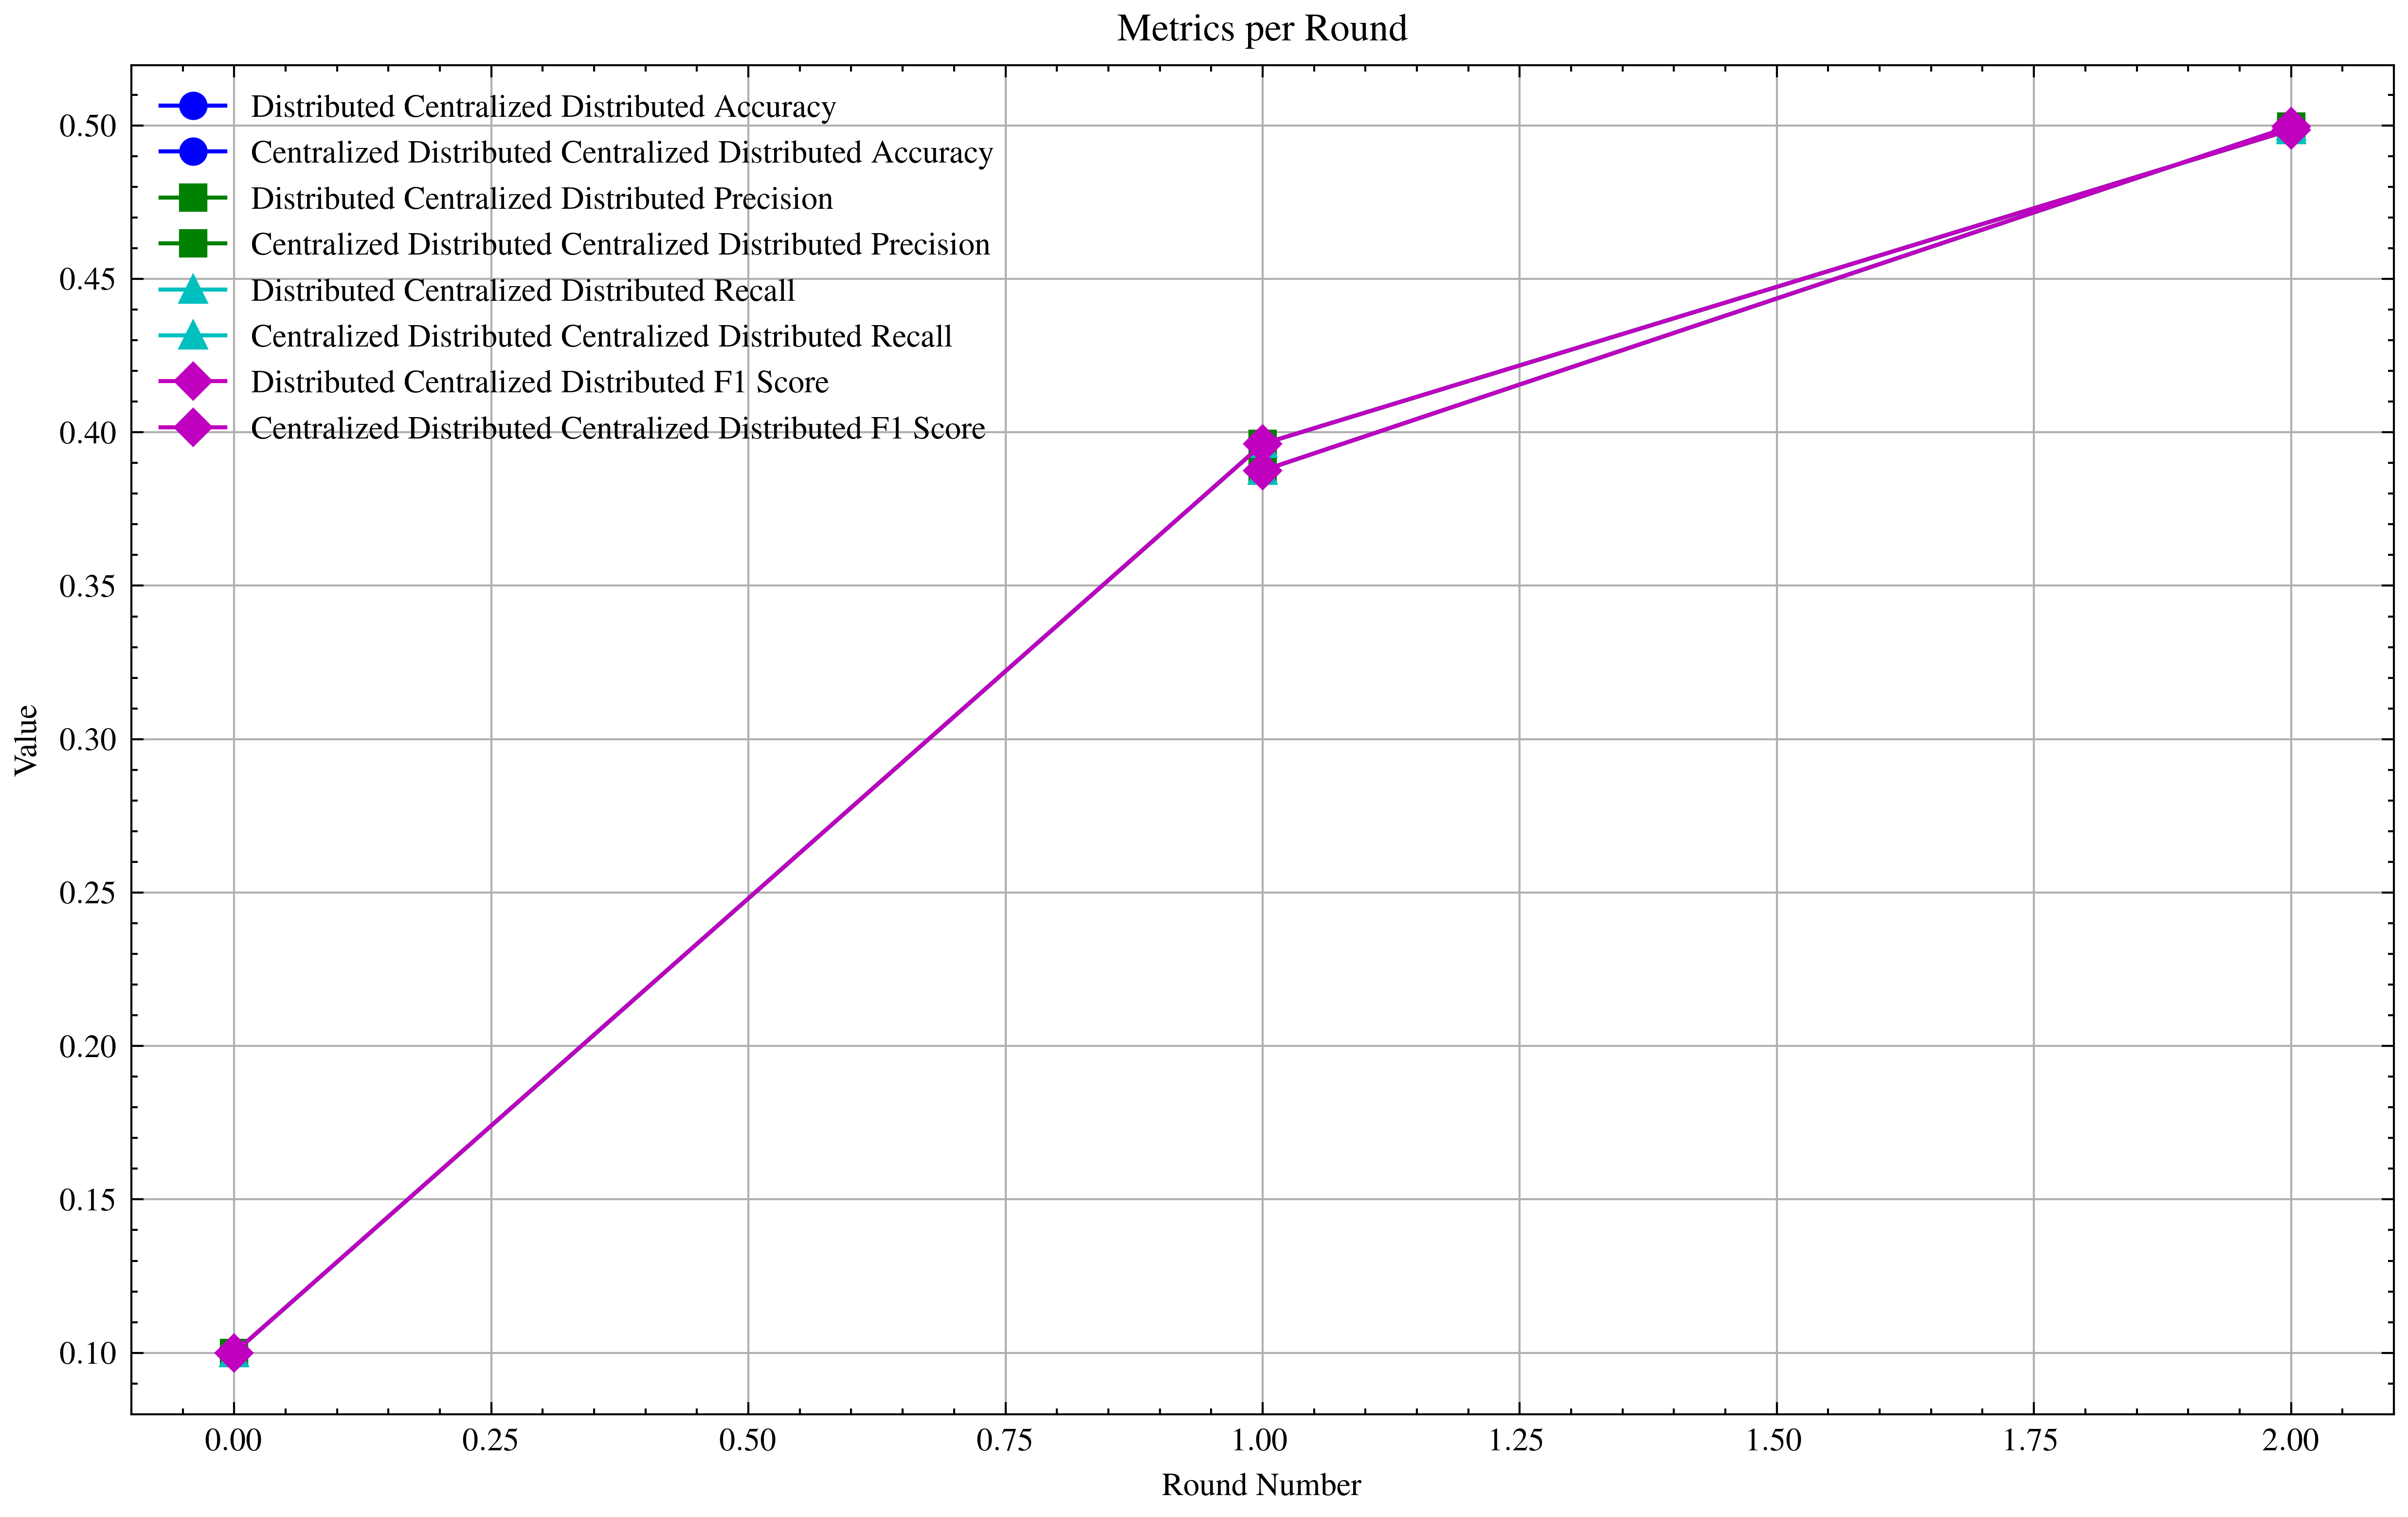

In [26]:

plot_metrics(history, [accuracy, loss, precision, recall, f1])